In [1]:
# a Kalman filter depends pretty heavily on different values of Q. What's the best one?

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats, signal, optimize

from aberrations import *
from observer import *

In [21]:
true_params = make_vibe_params(1)
print(true_params)
vibe_aberrations = make_1D_vibe_data(true_params)
r = 0.1
measurements = make_noisy_data(vibe_aberrations, noise=r)

[array([0.75784743]), array([209.44475344]), array([7.37772815e-05]), array([5.05946008])]


In [23]:
state, A, P, Q, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(measurements)), N=1))
A

array([[ 0.5088142 , -0.99714749],
       [ 1.        ,  0.        ]])

In [24]:
vibe_fit_freq(noise_filter(get_psd(measurements)), N=1)

(array([[2.09000000e+02, 1.08765623e-03]]), array([0.00017572]))

In [25]:
steps = vibe_aberrations.size

def kf_to_optimize(q):
    state, A, P, _, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(measurements)), N=1))
    Q = np.array([[q, 0], [0, 0]], dtype='float')
    states_freq = np.zeros((steps, state.size))
    for k in range(steps):
        state, P = update(H, P, R, state, measurements[k])
        states_freq[k] = state
        state, P = predict(A, P, Q, state)

    pos_freq = np.array([H.dot(state) for state in states_freq]).flatten()
    last_state = states_freq[-1]
    return np.sqrt(np.mean((pos_freq - vibe_aberrations)**2)), pos_freq, P, P[0][0]/(P[0][0] + R[0][0])


q0 = Q[0][0]
res = optimize.minimize(lambda q: kf_to_optimize(q)[0], [q0], method='Nelder-Mead')

In [26]:
print(q0)
res_base = kf_to_optimize(q0)
res_base[0]

0.00017571671226170957


0.1165140265130203

In [27]:
print(res.x[0])
res_opt = kf_to_optimize(res.x)
res_opt[0]

0.007828179531259163


0.05586433989751063

In [29]:
q_ARE = 0.0022
print(q_ARE)
res_ARE = kf_to_optimize(q_ARE)
res_ARE[0]

# I've got three runs of the same thing
# the first is a naive guessed value
# the second is a call to optimize.minimize (the 'dumb' solution) which you can't do online because it calls the full 
# loop hundreds of times whereas you need it to adapt in real time continuously in one run
# the third is the result of my matlab script that basically does derivative-type optimization without having to do
# multiple runs of the whole process, and with 'minimal' approximations I got it really close

0.0022


0.062278995467850415

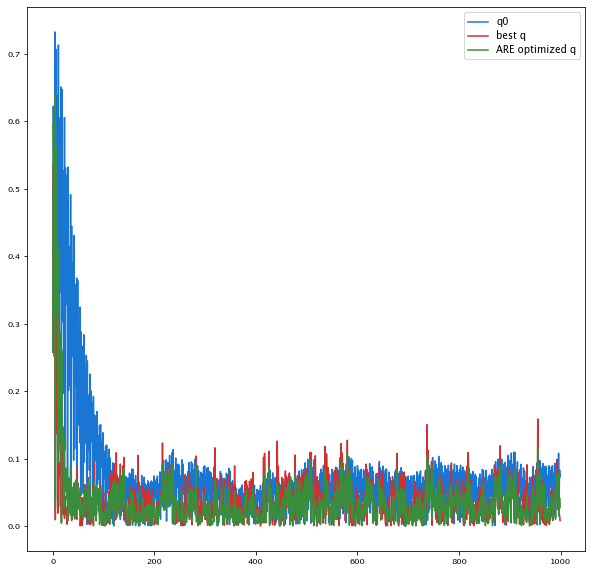

In [31]:
#plt.plot(vibe_aberrations, label='true')
plt.figure(figsize=(10,10))
plt.plot(np.abs(vibe_aberrations - res_base[1]), label='q0')
plt.plot(np.abs(vibe_aberrations - res_opt[1]), label='best q')
plt.plot(np.abs(vibe_aberrations - kf_to_optimize(q_ARE)[1]), label='ARE optimized q')
plt.legend()